In [65]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import os

In [4]:
os.path.abspath('classification of Chinese character.ipynb')

'/home/wonton/jiayi/projects/Chinese-charactor-classification/classification of Chinese character.ipynb'

In [86]:
size_IMG = 64
data_dir ="./commoncharacter>1250/"


In [87]:
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(size_IMG),
                                       transforms.ToTensor(),
                                       ])
    
    test_transforms = transforms.Compose([transforms.Resize(size_IMG),
                                      transforms.ToTensor(),
                                      ])
    
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    
    num_train = len(train_data)
    print("number of training data is", num_train)
    
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    
    np.random.shuffle(indices)
    
    
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

number of training data is 285656
['一', '丁', '七', '三', '上', '下', '不', '且', '世', '中', '丸', '丹', '主', '久', '之', '九', '也', '乳', '乾', '了', '予', '事', '二', '云', '五', '亡', '交', '亦', '享', '京', '亭', '亮', '人', '什', '仁', '仇', '今', '介', '他', '付', '代', '令', '以', '仰', '仲', '件', '任', '伐', '休', '伯', '似', '但', '位', '低', '住', '何', '余', '作', '使', '例', '供', '侵', '便', '俊', '俗', '保', '信', '修', '倍', '倒', '候', '借', '停', '健', '傍', '催', '像', '元', '兄', '兆', '先', '光', '入', '全', '八', '公', '六', '共', '兵', '其', '具', '典', '再', '冒', '冬', '冷', '凡', '出', '函', '刀', '分', '切', '刊', '列', '初', '判', '利', '到', '制', '刷', '券', '刻', '前', '副', '割', '力', '功', '加', '助', '努', '勇', '勉', '勤', '勺', '包', '化', '北', '十', '千', '午', '半', '卒', '南', '博', '占', '印', '危', '卵', '厚', '原', '去', '又', '及', '友', '反', '取', '受', '口', '古', '句', '只', '召', '可', '台', '史', '右', '司', '吃', '各', '合', '同', '名', '后', '吐', '向', '君', '否', '含', '吸', '告', '周', '味', '呼', '命', '和', '品', '唐', '唯', '唱', '商', '善', '喜', '嘉', '器', '四', '回', '因', '困', '固', '土', '在', '地', '均', 

In [82]:
classlen = len(trainloader.dataset.classes)

print('size of the classes is :', classlen)

size of the classes is : 978


In [83]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [84]:
for param in model.parameters():
    param.requires_grad = True
    
model.fc = nn.Sequential(nn.Linear(2048, 64),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(64, classlen),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [85]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()


Epoch 1/10.. Train loss: 6.907.. Test loss: 6.895.. Test accuracy: 0.001
Epoch 1/10.. Train loss: 6.900.. Test loss: 6.904.. Test accuracy: 0.001
Epoch 1/10.. Train loss: 6.907.. Test loss: 6.911.. Test accuracy: 0.001
Epoch 1/10.. Train loss: 6.889.. Test loss: 6.891.. Test accuracy: 0.001


KeyboardInterrupt: 

In [24]:
torch.save(model, 'SGD_whole.pth')

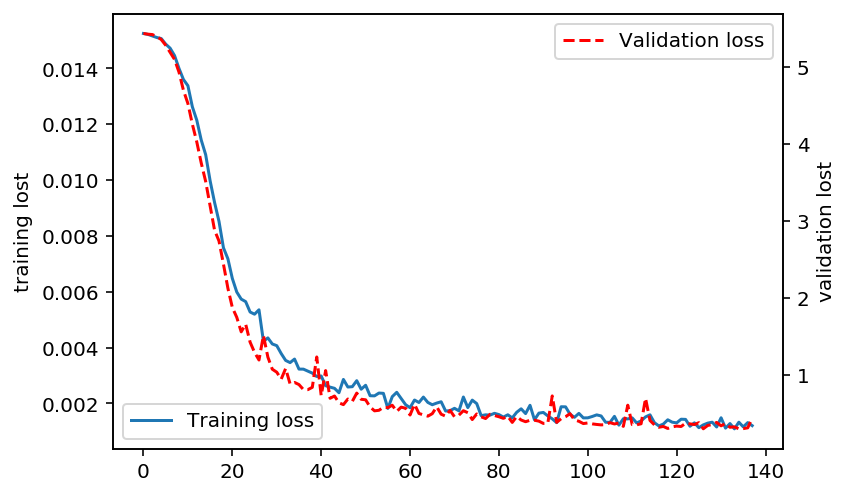

In [56]:
fig, ax1 = plt.subplots()
ax1.plot(train_losses, label='Training loss')
plt.ylabel("training lost")
ax1.legend(loc = 3)
ax2 = ax1.twinx()
ax2.plot(test_losses,"r--", label='Validation loss')
ax2.legend(loc = 1)
plt.ylabel("validation lost")
plt.show()

In [26]:
test_transforms = transforms.Compose([transforms.Resize(size_IMG),
                                      transforms.ToTensor(),
                                     ])

In [59]:
model.feature

AttributeError: 'ResNet' object has no attribute 'feature'

In [27]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model=torch.load('')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [77]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)

    index = output.data.cpu().numpy().argmax()
    return index

In [69]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, classes

In [70]:
print(trainloader.dataset.classes)


['一', '丁', '七', '三', '上', '下', '不', '且', '世', '中', '丸', '丹', '主', '久', '之', '九', '也', '乳', '乾', '了', '予', '事', '二', '云', '五', '亡', '交', '亦', '享', '京', '亭', '亮', '人', '什', '仁', '仇', '今', '介', '他', '付', '代', '令', '以', '仰', '仲', '件', '任', '伐', '休', '伯', '似', '但', '位', '低', '住', '何', '余', '作', '使', '例', '供', '侵', '便', '俊', '俗', '保', '信', '修', '倍', '倒', '候', '借', '停', '健', '傍', '催', '像', '元', '兄', '兆', '先', '光', '入', '全', '八', '公', '六', '共', '兵', '其', '具', '典', '再', '冒', '冬', '冷', '凡', '出', '函', '刀', '分', '切', '刊', '列', '初', '判', '利', '到', '制', '刷', '券', '刻', '前', '副', '割', '力', '功', '加', '助', '努', '勇', '勉', '勤', '勺', '包', '化', '北', '十', '千', '午', '半', '卒', '南', '博', '占', '印', '危', '卵', '厚', '原', '去', '又', '及', '友', '反', '取', '受', '口', '古', '句', '只', '召', '可', '台', '史', '右', '司', '吃', '各', '合', '同', '名', '后', '吐', '向', '君', '否', '含', '吸', '告', '周', '味', '呼', '命', '和', '品', '唐', '唯', '唱', '商', '善', '喜', '嘉', '器', '四', '回', '因', '困', '固', '土', '在', '地', '均', '垂', '型', '城', '域', '基', '堂', '堤',

助:True
停:True
五:True
命:True
夜:True


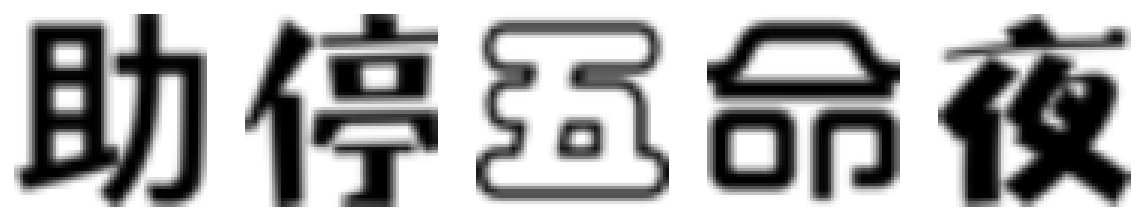

In [78]:
to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for k in range(len(images)):
    image = to_pil(images[k])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), k+1)
    res = int(labels[k]) == index
    print(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()